In [1]:
import math

import torch
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


n_ctx = 10
seqlen = 3
start_pos = 2
T = start_pos + seqlen
tokens = torch.randint(0, 100, (1, seqlen))

mask = torch.full((seqlen, seqlen), float("-inf"), device=tokens.device)
print(mask)
mask = torch.triu(mask, diagonal=1)
print(mask)
# When performing key-value caching, we compute the attention scores
# only for the new sequence. Thus, the matrix of scores is of size
# (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
# j > cache_len + i, since row i corresponds to token cache_len + i.
mask = torch.hstack([torch.zeros((seqlen, start_pos), device=tokens.device), mask])
print("mask 1")
print(mask)
mask_1 = mask

full_mask = torch.full((n_ctx, n_ctx), float("-inf"), device=tokens.device)
full_mask = torch.triu(full_mask, diagonal=1)
print(full_mask)
mask_2 = full_mask[start_pos : start_pos + seqlen, : start_pos + seqlen]
print("mask 2")
print(mask_2)

assert mask_1.all() == mask_2.all()


tensor([[-inf, -inf, -inf],
        [-inf, -inf, -inf],
        [-inf, -inf, -inf]])
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
mask 1
tensor([[0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask 2
tensor([[0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


In [2]:
d_head = 4
n_head = 2

# (B, n_head, T, d_head)
K = torch.randn(1, n_head, T, d_head)
V = torch.randn(1, n_head, T, d_head)
Q = torch.randn(1, n_head, seqlen, d_head)
print(f"{K.shape=}")
print(f"{V.shape=}")
print(f"{Q.shape=}")
attn_scores = Q @ K.transpose(-2, -1)
attn_scores = attn_scores / math.sqrt(d_head)
print(f"{attn_scores.shape=}")
attn_scores = attn_scores + mask_2
print(f"{attn_scores.shape=}")
attn = attn_scores.softmax(dim=-1)
print(f"{attn.shape=}")
print(attn)
z_og = attn @ V
print(f"{z_og.shape=}")
print(z_og)

z_flash = F.scaled_dot_product_attention(Q, K, V, is_causal=False, attn_mask=mask_2)
print(f"{z_flash.shape=}")
print(z_flash)


K.shape=torch.Size([1, 2, 5, 4])
V.shape=torch.Size([1, 2, 5, 4])
Q.shape=torch.Size([1, 2, 3, 4])
attn_scores.shape=torch.Size([1, 2, 3, 5])
attn_scores.shape=torch.Size([1, 2, 3, 5])
attn.shape=torch.Size([1, 2, 3, 5])
tensor([[[[0.3509, 0.3846, 0.2645, 0.0000, 0.0000],
          [0.1637, 0.7037, 0.1070, 0.0256, 0.0000],
          [0.2470, 0.2080, 0.2110, 0.1727, 0.1614]],

         [[0.5080, 0.3093, 0.1827, 0.0000, 0.0000],
          [0.3791, 0.0211, 0.5002, 0.0996, 0.0000],
          [0.0389, 0.7944, 0.0142, 0.1216, 0.0310]]]])
z_og.shape=torch.Size([1, 2, 3, 4])
tensor([[[[-0.4682,  0.9605,  0.0285, -0.8243],
          [ 0.4027,  1.4374,  0.2014, -0.8067],
          [-0.1386,  0.5987, -0.3582, -0.4968]],

         [[ 0.4254, -0.9034, -0.1598,  1.0039],
          [ 0.1877, -0.1839, -0.1506,  1.1675],
          [ 0.5940, -1.6980, -0.0383,  0.3529]]]])
z_flash.shape=torch.Size([1, 2, 3, 4])
tensor([[[[-0.4682,  0.9605,  0.0285, -0.8243],
          [ 0.4027,  1.4374,  0.2014, -0.8067]

In [11]:
import time

from gollem.models.gpt2.config import GPT2Config
from gollem.models.gpt2.config import get_gpt2_model_config
from gollem.models.gpt2.model import GPT


def generate_text(model: GPT, cfg: GPT2Config, x: torch.Tensor):
    model.to(device)
    x = x.to(device)
    time_start = time.time()
    B = x.size(0)
    output = torch.zeros((B, cfg.n_ctx), device=x.device)
    for i in range(cfg.n_ctx):
        logits = model.sample(x, start_pos=i)
        x = torch.argmax(logits, dim=-1)
        output[:, i] = x.squeeze(-1)
    time_taken = time.time() - time_start
    print(f"Time taken: {time_taken} seconds")
    return time_taken, output


def compute_expected_flops(cfg):
    B = cfg.max_sample_batch_size
    T = cfg.n_ctx
    d_model = cfg.d_model
    L = cfg.n_layer
    # (B*d_model)**2 per layer L per step T
    total_flops_caching = T * L * (B * d_model) ** 2
    # (B*d_model*i)**2 per layer L per step T
    # i = 1, 2, ..., T
    total_flops_no_caching = 0
    for i in range(1, T + 1):
        total_flops_no_caching += L * (B * d_model * i) ** 2
    print(f"{total_flops_caching=}")
    print(f"{total_flops_no_caching=}")
    print(f"speedup: {total_flops_no_caching / total_flops_caching}")


In [14]:
def test_kv_caching(max_sample_batch_size: int, n_ctx: int):
    print(
        f"Testing with max_sample_batch_size={max_sample_batch_size} and n_ctx={n_ctx}"
    )
    vocab_size = 100
    x = torch.randint(0, vocab_size, (max_sample_batch_size, 1)).to(device)
    # cfg = GPT2Config(
    #     vocab_size=100,
    #     n_ctx=n_ctx,
    #     n_layer=8,
    #     n_head=4,
    #     d_model=128,
    #     flash=True,
    #     max_sample_batch_size=max_sample_batch_size,
    #     use_kv_caching=False,
    # )
    cfg = get_gpt2_model_config("gpt2")
    cfg.n_ctx = n_ctx
    cfg.max_sample_batch_size = max_sample_batch_size
    cfg.use_kv_caching = False
    cfg.flash = True
    cfg.compile = False
    model = GPT(cfg)
    assert model.transformer.h[0].attn.cache_x is not None
    assert model.transformer.h[0].attn.cache_k is None
    assert model.transformer.h[0].attn.cache_v is None
    no_caching_time, no_caching_output = generate_text(model, cfg, x)

    cfg = GPT2Config.override(cfg, use_kv_caching=True)
    model = GPT(cfg)
    assert model.transformer.h[0].attn.cache_x is None
    assert model.transformer.h[0].attn.cache_k is not None
    assert model.transformer.h[0].attn.cache_v is not None
    caching_time, caching_output = generate_text(model, cfg, x)

    assert no_caching_output.allclose(caching_output)
    speedup = no_caching_time / caching_time

    # compute_expected_flops(cfg)
    return speedup, no_caching_time, caching_time


In [16]:
speedups = {}
for b in [1, 2, 4, 8, 16, 32, 64]:
    speedup, no_caching_time, caching_time = test_kv_caching(b, 1024)
    speedups[b] = (speedup, no_caching_time, caching_time)

print("B    | speedup")
print("-" * 10)
for b, speedup in speedups.items():
    print(f"{b:4d} | {speedup[0]:6.2f}")

Testing with max_sample_batch_size=1 and n_ctx=1024
Time taken: 4.260271787643433 seconds
Time taken: 3.814267158508301 seconds
Testing with max_sample_batch_size=2 and n_ctx=1024
Time taken: 5.769312143325806 seconds
Time taken: 3.751127243041992 seconds
Testing with max_sample_batch_size=4 and n_ctx=1024
Time taken: 8.570207595825195 seconds
Time taken: 3.7868080139160156 seconds
Testing with max_sample_batch_size=8 and n_ctx=1024
Time taken: 16.28174328804016 seconds
Time taken: 4.219985723495483 seconds
Testing with max_sample_batch_size=16 and n_ctx=1024
Time taken: 31.14762854576111 seconds
Time taken: 5.988429069519043 seconds
Testing with max_sample_batch_size=32 and n_ctx=1024
Time taken: 58.60583162307739 seconds
Time taken: 8.5898756980896 seconds
Testing with max_sample_batch_size=64 and n_ctx=1024
Time taken: 115.17988801002502 seconds
Time taken: 14.444243431091309 seconds
B    | speedup
----------
   1 |   1.12
   2 |   1.54
   4 |   2.26
   8 |   3.86
  16 |   5.20
  32

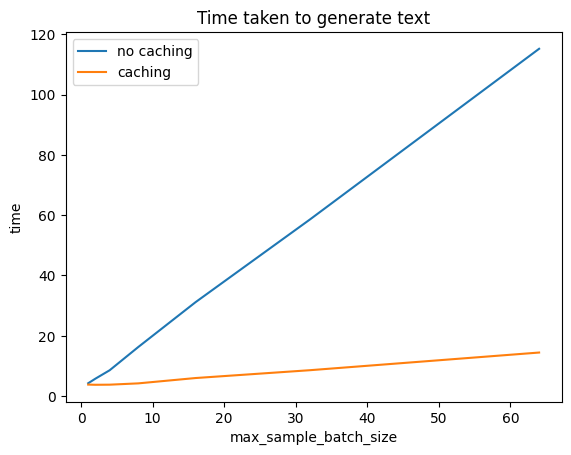

In [17]:
import matplotlib.pyplot as plt


no_caching_times = [speedup[1] for speedup in speedups.values()]
caching_times = [speedup[2] for speedup in speedups.values()]

plt.plot(list(speedups.keys()), no_caching_times, label="no caching")
plt.plot(list(speedups.keys()), caching_times, label="caching")
plt.xlabel("max_sample_batch_size")
plt.ylabel("time")
plt.title("Time taken to generate text")
plt.legend()
plt.show()


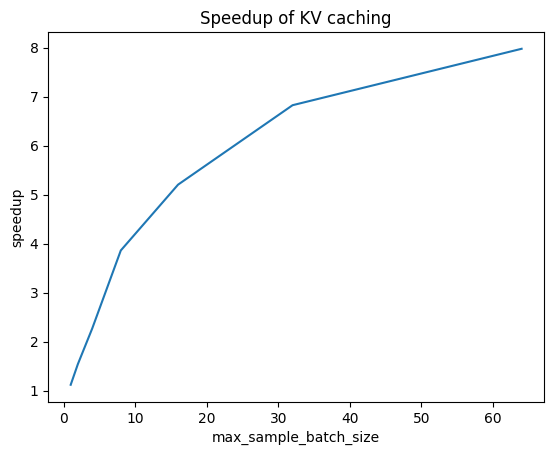

In [18]:
plt.plot(list(speedups.keys()), [speedup[0] for speedup in speedups.values()])
plt.xlabel("max_sample_batch_size")
plt.ylabel("speedup")
plt.title("Speedup of KV caching")
plt.show()


In [19]:
speedups_n_ctx = {}
for n_ctx in [128, 256, 512, 1024, 2048, 4096]:
    speedup, no_caching_time, caching_time = test_kv_caching(1, n_ctx)
    speedups_n_ctx[n_ctx] = (speedup, no_caching_time, caching_time)

print("B    | speedup")
print("-" * 10)
for b, speedup in speedups_n_ctx.items():
    print(f"{b:4d} | {speedup[0]:6.2f}")

Testing with max_sample_batch_size=1 and n_ctx=128
Time taken: 0.47638940811157227 seconds
Time taken: 0.47612714767456055 seconds
Testing with max_sample_batch_size=1 and n_ctx=256
Time taken: 0.9562084674835205 seconds
Time taken: 0.9963343143463135 seconds
Testing with max_sample_batch_size=1 and n_ctx=512
Time taken: 1.8794162273406982 seconds
Time taken: 1.912750244140625 seconds
Testing with max_sample_batch_size=1 and n_ctx=1024
Time taken: 4.21628999710083 seconds
Time taken: 3.8016269207000732 seconds
Testing with max_sample_batch_size=1 and n_ctx=2048
Time taken: 12.45892071723938 seconds
Time taken: 8.624280452728271 seconds
Testing with max_sample_batch_size=1 and n_ctx=4096
Time taken: 45.59790349006653 seconds
Time taken: 25.24828553199768 seconds
B    | speedup
----------
 128 |   1.00
 256 |   0.96
 512 |   0.98
1024 |   1.11
2048 |   1.44
4096 |   1.81


Text(0.5, 1.0, 'Time taken to generate text with different n_ctx')

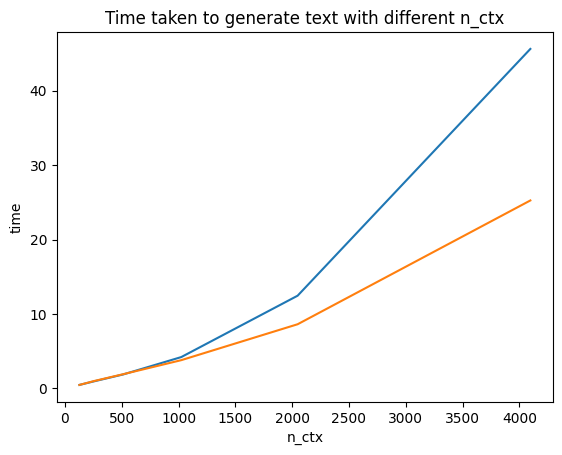

In [20]:
no_caching_times_n_ctx = [speedup[1] for speedup in speedups_n_ctx.values()]
caching_times_n_ctx = [speedup[2] for speedup in speedups_n_ctx.values()]

plt.plot(list(speedups_n_ctx.keys()), no_caching_times_n_ctx, label="no caching")
plt.plot(list(speedups_n_ctx.keys()), caching_times_n_ctx, label="caching")
plt.xlabel("n_ctx")
plt.ylabel("time")
plt.title("Time taken to generate text with different n_ctx")

Text(0.5, 1.0, 'Speedup of KV caching with different n_ctx')

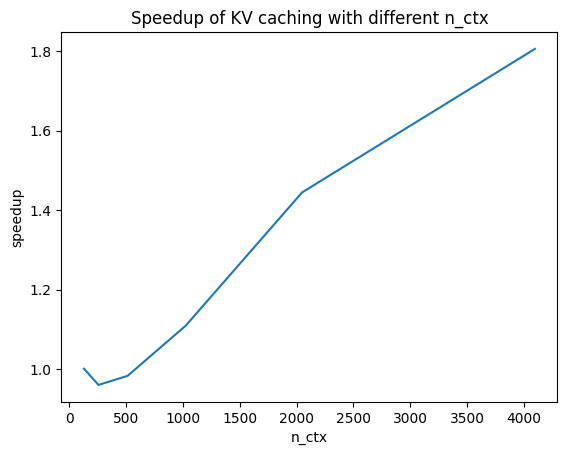

In [22]:
plt.plot(
    list(speedups_n_ctx.keys()), [speedup[0] for speedup in speedups_n_ctx.values()]
)
plt.xlabel("n_ctx")
plt.ylabel("speedup")
plt.title("Speedup of KV caching with different n_ctx")